In [8]:
import pandas as pd
import numpy as np
import plotnine as p9
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
plt.style.use('ggplot')

In [2]:
pred_data = pd.read_csv('../data/pred_data.csv',dtype={'FIPS': str, 'hold_out_fips': str})
week_data = pd.read_csv('../data/week_sum_demo.csv',dtype={'FIPS':str})

In [3]:
week_data['date'] = pd.DatetimeIndex([a[0] for a in week_data['week'].str.split('/')])

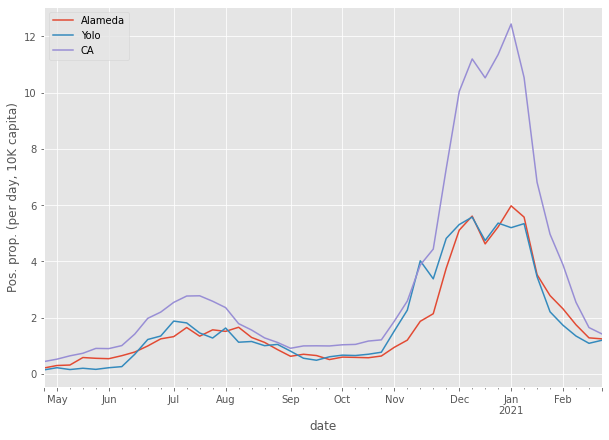

In [4]:
fig = plt.figure(figsize=(10,7))
week_data.query('FIPS=="06001"').set_index('date').eval('pos_results / days_by_10kpop').plot(label='Alameda')
week_data.query('FIPS=="06113"').set_index('date').eval('pos_results / days_by_10kpop').plot(label='Yolo')
week_data.groupby('date').sum().eval('pos_results / days_by_10kpop').plot(label='CA')
plt.legend()
plt.ylabel('Pos. prop. (per day, 10K capita)')
plt.savefig('../figs/yolo_alameda.png')

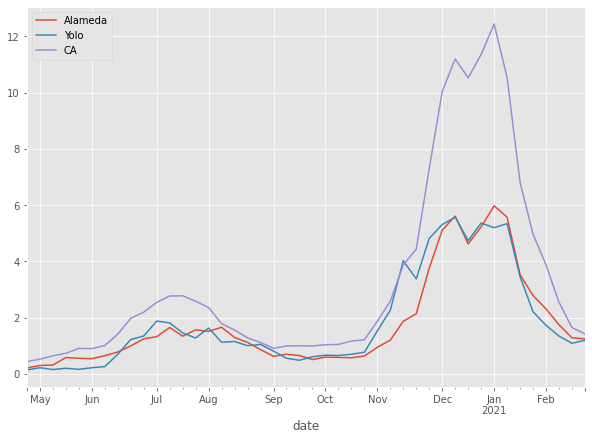

In [23]:
fig = plt.figure(figsize=(10,7))
ax = week_data.query('FIPS=="06001"').set_index('date').eval('pos_results / days_by_10kpop').plot(label='Alameda')
week_data.query('FIPS=="06113"').set_index('date').eval('pos_results / days_by_10kpop').plot(label='Yolo', ax=ax)
week_data.groupby('date').sum().eval('pos_results / days_by_10kpop').plot(label='CA', ax=ax)
plt.legend()

handles, labels = ax.get_legend_handles_labels() # return lines and labels
interactive_legend = plugins.InteractiveLegendPlugin(zip(handles,
                                                         ax.get_lines()),
                                                     labels,
                                                     alpha_unsel=0.5,
                                                     alpha_over=1.5, 
                                                     start_visible=True)

# mpld3.display(fig)
mpld3.save_html(fig, 'yolo_alameda.html')

In [21]:
ax.get_lines()

<a list of 3 Line2D objects>

In [13]:
sum_data = week_data.groupby('FIPS').sum()[['pos_results','days_by_10kpop']]
sum_data['pos_prop'] = sum_data.eval('pos_results / days_by_10kpop')

In [14]:
res_data = pred_data[['FIPS','hold_out_fips','pos_pred']].join(sum_data, on='FIPS')

In [15]:
res_data['perc_diff'] = res_data.eval('pos_results / pos_pred - 1')
res_data['pos_prop_pred'] = res_data.eval('pos_pred / days_by_10kpop')

In [16]:
res_data

,FIPS,hold_out_fips,pos_pred,pos_results,days_by_10kpop,pos_prop,perc_diff,pos_prop_pred
0,06003,06001,24.799278,26.0,33.87,0.767641,0.048418,0.732190
1,06005,06001,1107.093856,1776.0,1192.56,1.489233,0.604200,0.928334
2,06007,06001,8620.722772,11491.0,6575.58,1.747526,0.332951,1.311021
3,06009,06001,1010.179736,2033.0,1377.15,1.476237,1.012513,0.733529
4,06011,06001,2014.374874,1685.0,646.41,2.606705,-0.163512,3.116250
...,...,...,...,...,...,...,...,...
3301,06105,06115,171.004303,306.0,368.55,0.830281,0.789429,0.463992
3302,06107,06115,57663.777482,50880.0,13985.85,3.637963,-0.117644,4.123008
3303,06109,06115,1271.610386,4446.0,1634.34,2.720364,2.496354,0.778057
3304,06111,06115,76677.330642,92649.0,25380.18,3.650447,0.208297,3.021150


In [17]:
out_vars = ['pos_pred', 'pos_prop_pred', 'perc_diff']

jack_mean = res_data[['FIPS'] + out_vars].groupby('FIPS').mean()

jack_count = res_data[['FIPS'] + out_vars].groupby('FIPS').count()


jack_se = res_data[['FIPS'] + out_vars].groupby('FIPS').std() * (jack_count - 1) / jack_count**0.5

jack_preds = jack_mean.join(jack_se, rsuffix='_se')

In [18]:
jack_preds['perc_diff_z'] = jack_preds.eval('perc_diff / perc_diff_se')

In [19]:
comp_data = jack_preds.join(sum_data[['pos_results', 'pos_prop']])

In [20]:
comp_data = comp_data.sort_values('perc_diff')

In [21]:
comp_data['pos_pred_pr'] = comp_data['pos_pred'].round(1).astype(str) + ' (' + comp_data['pos_pred_se'].round(1).astype(str) + ')'

comp_data['pos_prop_pr'] = comp_data['pos_prop'].round(2).astype(str)

comp_data['perc_diff_pr'] = comp_data['perc_diff'].round(2).astype(str) + ' (' + comp_data['perc_diff_se'].round(2).astype(str) + ')'

comp_data['pos_prop_pred_pr'] = comp_data['pos_prop_pred'].round(2).astype(str) + ' (' + comp_data['pos_prop_pred_se'].round(2).astype(str) + ')'


In [22]:
county_names = pd.read_csv('../data/county_names.csv',dtype=str)

In [23]:
comp_data = comp_data.join(county_names.set_index('FIPS'))

In [26]:
comp_data.to_csv('../figs/comp_data.csv')

In [25]:
print(comp_data.set_index('County')[['pos_prop_pr','pos_prop_pred_pr', 'perc_diff_pr']].to_latex())

\begin{tabular}{llll}
\toprule
{} & pos\_prop\_pr & pos\_prop\_pred\_pr &  perc\_diff\_pr \\
County          &             &                  &               \\
\midrule
Alameda         &        1.81 &      3.03 (0.38) &   -0.4 (0.08) \\
Yolo            &        1.87 &      3.02 (0.62) &  -0.38 (0.13) \\
Contra Costa    &        1.92 &       2.79 (0.4) &   -0.31 (0.1) \\
Santa Clara     &        2.04 &      2.87 (0.42) &  -0.29 (0.11) \\
Santa Cruz      &        1.63 &      2.27 (0.34) &  -0.28 (0.11) \\
Sierra          &        0.47 &      0.64 (0.11) &  -0.27 (0.13) \\
San Francisco   &        1.61 &       2.13 (0.5) &  -0.24 (0.17) \\
Solano          &         2.2 &      2.91 (0.59) &  -0.24 (0.16) \\
Modoc           &        0.57 &      0.74 (0.14) &  -0.23 (0.14) \\
Merced          &        3.45 &      4.43 (0.55) &   -0.22 (0.1) \\
Humboldt        &         0.8 &      1.01 (0.25) &   -0.2 (0.19) \\
San Benito      &        3.32 &      4.15 (0.85) &   -0.2 (0.17) \\
Kern          

In [188]:
betas = pd.read_csv('../data/beta_jackknife.csv')

In [189]:
n = betas.shape[0]
beta_mean = betas.iloc[:,1:].mean()
beta_se = (n - 1) / n**0.5 * betas.iloc[:,1:].std()

In [190]:
betas.shape

(58, 9)

In [196]:
pred_vars = ['youth','seniors','hispanic_pop','black_pop','asian_pop','pov_prop','bac_prop','ca_prop']

In [198]:
Betas = pd.DataFrame({
    'var': pred_vars,
    'coef': beta_mean,
    'se': beta_se,
    't': beta_mean / beta_se
}).set_index('var')

In [200]:
print(Betas.round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  coef &    se &      t \\
var          &       &       &        \\
\midrule
youth        & -0.24 &  0.71 &  -0.34 \\
seniors      & -1.02 &  0.79 &  -1.30 \\
hispanic\_pop &  0.63 &  0.21 &   2.98 \\
black\_pop    &  0.14 &  0.13 &   1.04 \\
asian\_pop    &  0.03 &  0.18 &   0.18 \\
pov\_prop     &  0.34 &  0.75 &   0.45 \\
bac\_prop     &  0.05 &  0.35 &   0.16 \\
ca\_prop      &  1.14 &  0.03 &  33.54 \\
\bottomrule
\end{tabular}



In [203]:
yolo_data = pd.read_csv('../data/yolo_data.csv')

In [243]:
yolo_stats = yolo_data.groupby(['FIPS','week']).describe()['pos_prop_pred']

In [245]:
yolo_stats['se'] = yolo_stats.eval('(count - 1) / count**0.5 * std')

In [246]:
se1_low = yolo_stats.eval('mean - 1*se').values
se1_high = yolo_stats.eval('mean + 1*se').values
se2_low = yolo_stats.eval('mean - 2*se').values
se2_high = yolo_stats.eval('mean + 2*se').values
weeks = np.arange(1,len(se1_low)+1)

In [253]:
ca_prop = week_data.groupby('week').sum().eval('pos_results / days_by_10kpop')

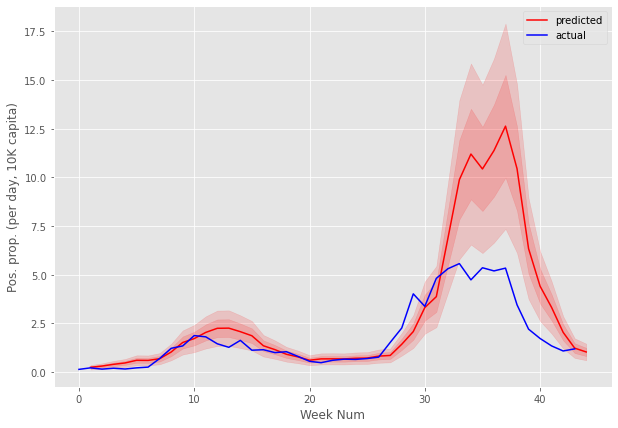

In [267]:
plt.figure(figsize=(10,7))
plt.fill_between(weeks, se1_low, se1_high, alpha=.15, color='r')
plt.fill_between(weeks, se2_low, se2_high, alpha=.15, color='r')
plt.plot(weeks,yolo_stats['mean'], color='r',label='predicted')
plt.plot(week_data.query("FIPS=='06113'").eval('pos_results / days_by_10kpop').values, color='b', label='actual')
# plt.plot(weeks,ca_prop.values, color='black')
plt.legend()
plt.xlabel('Week Num')
plt.ylabel('Pos. prop. (per day, 10K capita)')
plt.savefig('../figs/lm_yolo_act_pred_jack.png')